## Создание ML-моделей 

### Библиотеки и пользовательские функции

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [3]:
def create_df():
    '''
    Функция для создания датафрейма для сохранения метрик
    
    '''
    df = pd.DataFrame(columns=['Модель',
                               'Прогнозируемая переменная',
                               'Лучшие параметры',
                               'Среднеквадратическая ошибка (MSE)',
                               'Коэффициент детерминации (R^2)']
                      ).set_index(['Модель'])
    return df

In [4]:
def tune_model(model, param_grid):
    '''
    Функция подбора гиперпараметров
    Выводит и возвращает словарь с параметрами
    
    '''
    
    # Поиск по сетке
    grid_search = GridSearchCV(
                               model,
                               param_grid=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=cv,
                               verbose=True, n_jobs=-1
                               )
    grid_search.fit(X_train, y_module_train)
    
    # Лучшие параметры
    print()
    print(
          pd.DataFrame(grid_search.best_params_,
          index=[f'Параметры лучшей модели {type(model).__name__}']).T
          )
    
    return grid_search.best_params_


In [5]:
def save_model(model, best_param, models_dict):
    '''
    Функция сохраняет модель и выбранные параметры  в словарь models_dict...
    
    '''
    
    model_name = type(model).__name__
    models_dict[model_name] = {
          'model': model,
          'params': best_param
                              }

Функции для оценивания моделей кросс-валидацией

In [6]:
# для модуля упругости при растяжении

def score_module(model, best_param):
    '''
    Функция, рассчитывающая метрики MSE и R2
    Печатает метрики
    Вносит метрики в итоговую таблицу
    Сохраняет модель в словарь
    
    '''
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2"]
    
    # расчет на кросс-валидации
    scores = cross_validate(model, X_train, y_module_train, cv=cv, scoring=scoring, n_jobs=-1)
    # scores  возвращает словарь
    
    # вывод оценок
    print(f'Оценка {type(model).__name__} на обучающей выборке')
    print("Mean MSE:", -scores["test_neg_mean_squared_error"].mean().round(4), "±", scores["test_neg_mean_squared_error"].std().round(4))
    print("Mean R^2:", scores["test_r2"].mean().round(4), "±", scores["test_r2"].std().round(4))
    
    # заполнение датафрейма оценками
    df_module.loc[type(model).__name__] = ['Модуль упругости при растяжении',
                                            best_param,
    f"{-scores['test_neg_mean_squared_error'].mean():.3f} ± {scores['test_neg_mean_squared_error'].std():.3f}",
    f"{scores['test_r2'].mean():.3f} ± {scores['test_r2'].std():.3f}"]
    
    # пользовательская функция сохранения модели в словарь
    save_model(model, best_param, models_dict_module)


In [7]:
# для прочности при растяжении

def score_strength(model, best_param):
    '''
    Функция, рассчитывающая метрики MSE и R2
    Печатает метрики
    Вносит метрики в итоговую таблицу
    Сохраняет модель в словарь
    
    '''
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2"]
    
    # расчет на кросс-валидации
    scores = cross_validate(model, X_train, y_strength_train, cv=cv, scoring=scoring, n_jobs=-1)
    # scores  возвращает словарь
    
    # вывод оценок
    print(f'Оценка {type(model).__name__} на обучающей выборке')
    print("Mean MSE:", -scores["test_neg_mean_squared_error"].mean().round(4), "±", scores["test_neg_mean_squared_error"].std().round(4))
    print("Mean R^2:", scores["test_r2"].mean().round(4), "±", scores["test_r2"].std().round(4))
    
    # заполнение датафрейма оценками
    df_strength.loc[type(model).__name__] = ['Прочность при растяжении',
                                              best_param,
    f"{-scores['test_neg_mean_squared_error'].mean():.3f} ± {scores['test_neg_mean_squared_error'].std():.3f}",
    f"{scores['test_r2'].mean():.3f} ± {scores['test_r2'].std():.3f}"]
    
    # пользовательская функция сохранения модели в словарь
    save_model(model, best_param, models_dict_strength)


Функция для оценивания моделей на тестовой выборке

In [8]:
def test(models_dict, y_train, y_test):
    '''
    Функция оценки модели на тестовой выборке
    
    '''
    
    # пустой датафрейм
    df = create_df()
    
    # для каждой модели в словаре моделей
    for name, model_dict in models_dict.items():
        # извлекаем модель
        model = model_dict['model']
        # извлекаем параметры
        best_param = model_dict['params']
        
        # обучение модели на train-выборке и прогноз на test-выборке
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # оценка качества прогнозов на тестовой выборке
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        # заполнение датафрейма оценками
        df.loc[type(model).__name__] = [y_train.name[:-5],
                                        best_param,
                                        f"{mse:.3f}",
                                        f"{r2:.3f} "]
    
    return df

In [9]:

# Стратегия перекрестной проверки
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=0)


### Подготовка данных

In [10]:
data = pd.read_csv('../data/processed.csv')
data.columns

Index(['Количество отвердителя, м.%', 'Содержание эпоксидных групп, %',
       'Температура вспышки, С', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки',
       'Плотность, кг/м3', 'Поверхностная плотность, г/м2',
       'Модуль упругости, ГПа', 'Соотношение матрица-наполнитель',
       'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа'],
      dtype='object')

In [11]:
module = data['Модуль упругости при растяжении, ГПа']   # целевая переменная
strength = data['Прочность при растяжении, МПа']        # целевая переменная

X = data.drop(columns=
              ['Модуль упругости при растяжении, ГПа',  # признаки
               'Прочность при растяжении, МПа'])
len(X.columns)

11

In [12]:
# Разбиваем на train и test

X_train, X_test,                    \
y_module_train, y_module_test,      \
y_strength_train, y_strength_test = \
train_test_split(
                 X, module, strength, test_size=0.3, random_state=0
                )

print(X_train.shape, y_module_train.shape, y_strength_train.shape)
print(X_test.shape, y_module_test.shape, y_strength_test.shape)

(655, 11) (655,) (655,)
(281, 11) (281,) (281,)


<font color=blue size=4>**Прогноз модуля упругости при растяжении**</font>  
переменная `module`

Метрики оценивания:
- MSE - mean squared error - среднеквадратическая ошибка  
- R<sup>2</sup> - коэффициент детерминации

In [13]:

# Датафрейм для записи MSE и R2
df_module = create_df()

# Пустой словарь для перечня моделей и их параметров
models_dict_module = {}


#### Градиентный бустинг  XGBoost
https://neerc.ifmo.ru/wiki/index.php?title=XGBoost

In [14]:
param_xgb = {
              'booster': ['gbtree', 'dart'],            # dart - c прорежеванием
              'n_estimators': [10, 50, 100, 500],       # число деревьев
              'max_depth': [3, 5, 7, 10],               # максимальная глубина дерева
              'learning_rate': [0.01, 0.02, 0.1, 0.3],
              'subsample': [0.5, 0.7, 1.0],             # доля обучающих образцов
              'colsample_bytree': [0.5, 0.7, 1.0],      # доля обучающих признаков
              'n_jobs': [-1]
             }

Используем среднеквадратическую ошибку MSE в качестве функции потерь, в xgboost - squarederror задана по умолчанию. Оптимизация модели заключается в нахождении такого набора параметров модели, при котором среднее значение квадратов разностей между фактическими и прогнозируемыми значениями будет минимальным.

In [15]:

xgb = XGBRegressor(random_state=0)   # tree_method="gpu_hist"

# Функция подбора гиперпараметров
best_param_xgb = tune_model(xgb, param_xgb)


Fitting 20 folds for each of 1152 candidates, totalling 23040 fits

                 Параметры лучшей модели XGBRegressor
booster                                          dart
colsample_bytree                                  0.5
learning_rate                                    0.02
max_depth                                          10
n_estimators                                       10
n_jobs                                             -1
subsample                                         0.7


In [16]:

# Создание модели с лучшими параметрами
best_xgb = XGBRegressor(random_state=0, **best_param_xgb)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_xgb, best_param_xgb)


Оценка XGBRegressor на обучающей выборке
Mean MSE: 0.0391 ± 0.0065
Mean R^2: -0.0111 ± 0.021


#### Градиентный бустинг CatBoost

In [17]:
param_catboost = {
                 'learning_rate': [0.01, 0.1],
                 'depth': [4, 6, 7, 10],         # глубина дерева решений
                 'l2_leaf_reg': [0.1, 1, 10],    # коэффициент регуляризации L2
                 'iterations': [10, 50, 100]     # количество итераций обучения
                  }

In [18]:

# по умолчанию все ядра процессора
# task_type="GPU"

catboost = CatBoostRegressor(random_state=0, logging_level='Silent')

# Функция подбора гиперпараметров
best_param_catboost = tune_model(catboost, param_catboost)


Fitting 20 folds for each of 72 candidates, totalling 1440 fits

               Параметры лучшей модели CatBoostRegressor
depth                                              10.00
iterations                                         10.00
l2_leaf_reg                                        10.00
learning_rate                                       0.01


In [19]:

# Создание модели с лучшими параметрами
best_catboost = CatBoostRegressor(random_state=0, **best_param_catboost)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_catboost, best_param_catboost)


Оценка CatBoostRegressor на обучающей выборке
Mean MSE: 0.039 ± 0.0065
Mean R^2: -0.0101 ± 0.0143


#### Случайный лес

In [20]:
param_forest = {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 5, 7],
                'min_samples_split': [2, 4, 8],
                'min_samples_leaf': [1, 2, 4],
               }

In [21]:

forest = RandomForestRegressor(random_state=0)

# Функция подбора гиперпараметров
best_param_forest = tune_model(forest, param_forest)


Fitting 20 folds for each of 108 candidates, totalling 2160 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      2
min_samples_leaf                                               1
min_samples_split                                              2
n_estimators                                                 200


In [22]:

# Создание модели с лучшими параметрами
best_forest = RandomForestRegressor(random_state=0, **best_param_forest)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_forest, best_param_forest)


Оценка RandomForestRegressor на обучающей выборке
Mean MSE: 0.0396 ± 0.0065
Mean R^2: -0.0251 ± 0.0256


#### Полиномиальная регрессия  
Полиномиальная интерполяция с Ridge регрессией  
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

In [23]:
param_poly = {
              'polynomialfeatures__degree': range(1, 5),
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
             }

In [24]:

poly = make_pipeline(PolynomialFeatures(), Ridge())

# Функция подбора гиперпараметров
best_param_poly = tune_model(poly, param_poly)


Fitting 20 folds for each of 24 candidates, totalling 480 fits

                            Параметры лучшей модели Pipeline
polynomialfeatures__degree                                 1
ridge__alpha                                             100


In [25]:

# Создание модели с лучшими параметрами
best_poly = make_pipeline(
            PolynomialFeatures(degree=best_param_poly['polynomialfeatures__degree']),
            Ridge(alpha=best_param_poly['ridge__alpha']))

# Функция, рассчитывающая метрики MSE и R2
score_module(best_poly, best_param_poly)


Оценка Pipeline на обучающей выборке
Mean MSE: 0.0391 ± 0.0065
Mean R^2: -0.012 ± 0.0166


In [26]:
# Проверим словарь с моделями
models_dict_module

{'XGBRegressor': {'model': XGBRegressor(base_score=None, booster='dart', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
               random_state=0, ...),
  'params': {'booster': 'dart',
   'colsample_bytree': 0.5,
   'learning_rate': 0.02,
   'max_depth': 10,
   'n_estimators': 10,
   'n_jobs': -1,
   'subsample': 0.7}},
 'CatBoostRegressor': {'model': <catboost.core.Ca

<font color=blue size=4>**Прогноз прочности при растяжении**</font>  
переменная `strength`

In [27]:

# Датафрейм для записи MSE и R2
df_strength = create_df()

# Пустой словарь для перечня моделей и их параметров
models_dict_strength = {}


Воспользуемся теми же словарями с гиперпараметрами, что и для моделей для модуля упругости при растяжении  
#### Градиентный бустинг  XGBoost

In [28]:

xgb_strength = XGBRegressor(random_state=0)   # tree_method="gpu_hist"

# Функция подбора гиперпараметров
best_param_xgb_strength = tune_model(xgb_strength, param_xgb)


Fitting 20 folds for each of 1152 candidates, totalling 23040 fits

                 Параметры лучшей модели XGBRegressor
booster                                          dart
colsample_bytree                                  0.5
learning_rate                                    0.02
max_depth                                          10
n_estimators                                       10
n_jobs                                             -1
subsample                                         0.7


In [29]:

# Создание модели с лучшими параметрами
best_xgb_strength = XGBRegressor(random_state=0, **best_param_xgb_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_xgb_strength, best_param_xgb_strength)


Оценка XGBRegressor на обучающей выборке
Mean MSE: 0.0351 ± 0.0047
Mean R^2: -0.0248 ± 0.0337


#### Градиентный бустинг CatBoost

In [30]:

catboost_strength = CatBoostRegressor(random_state=0, logging_level='Silent')

# Функция подбора гиперпараметров
best_param_catboost_strength = tune_model(catboost_strength, param_catboost)


Fitting 20 folds for each of 72 candidates, totalling 1440 fits

               Параметры лучшей модели CatBoostRegressor
depth                                              10.00
iterations                                         10.00
l2_leaf_reg                                        10.00
learning_rate                                       0.01


In [31]:

# Создание модели с лучшими параметрами
best_catboost_strength = CatBoostRegressor(random_state=0, **best_param_catboost_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_catboost_strength, best_param_catboost_strength)


Оценка CatBoostRegressor на обучающей выборке
Mean MSE: 0.0349 ± 0.0048
Mean R^2: -0.0187 ± 0.0184


#### Случайный лес

In [32]:

forest_strength = RandomForestRegressor(random_state=0)

# Функция подбора гиперпараметров
best_param_forest_strength = tune_model(forest_strength, param_forest)


Fitting 20 folds for each of 108 candidates, totalling 2160 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      2
min_samples_leaf                                               1
min_samples_split                                              2
n_estimators                                                 200


In [33]:

# Создание модели с лучшими параметрами
best_forest_strength = RandomForestRegressor(random_state=0, **best_param_forest_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_forest_strength, best_param_forest_strength)


Оценка RandomForestRegressor на обучающей выборке
Mean MSE: 0.0354 ± 0.0046
Mean R^2: -0.0347 ± 0.0299


#### Полиномиальная регрессия  

In [34]:

poly_strength = make_pipeline(PolynomialFeatures(), Ridge())

# Функция подбора гиперпараметров
best_param_poly_strength = tune_model(poly_strength, param_poly)


Fitting 20 folds for each of 24 candidates, totalling 480 fits

                            Параметры лучшей модели Pipeline
polynomialfeatures__degree                                 1
ridge__alpha                                             100


In [35]:

# Создание модели с лучшими параметрами
best_poly_strength = make_pipeline(
                     PolynomialFeatures(
                         degree=best_param_poly_strength['polynomialfeatures__degree']),
                     Ridge(
                         alpha=best_param_poly_strength['ridge__alpha']))

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_poly_strength, best_param_poly_strength)


Оценка Pipeline на обучающей выборке
Mean MSE: 0.035 ± 0.0048
Mean R^2: -0.0196 ± 0.0202


In [36]:
# Проверим словарь с моделями
models_dict_strength

{'XGBRegressor': {'model': XGBRegressor(base_score=None, booster='dart', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
               random_state=0, ...),
  'params': {'booster': 'dart',
   'colsample_bytree': 0.5,
   'learning_rate': 0.02,
   'max_depth': 10,
   'n_estimators': 10,
   'n_jobs': -1,
   'subsample': 0.7}},
 'CatBoostRegressor': {'model': <catboost.core.Ca

Сравнив точность моделей для двух прогнозируемых переменных (модуля упругости при растяжении и прочности при растяжении) на обучающей выборке, можно сделать предварительный вывод, что лучшей моделью является градиентный бустинг CatBoost для модуля упругости при растяжении. Рассчитанный коэффициент детерминации для CatBoost имеет максимальную величину -0.01.  
При этом для всех моделей характерен отрицательный коэфиициент детерминации, а их среднеквадратическая ошибка близка. Отрицательный коэффициент детерминации говорит об отсутствии взаимосвязи в данных. Вследствие чего, ни одна модель не обладает высокой прогнозирующей способностью.

**<p style="text-align: center;">Сравнительные таблицы ошибок и коэффицентов детерминации</p>**  
**<p style="text-align: center;">различных моделей на обучающей выборке</p>**

In [37]:
df_module

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Модуль упругости при растяжении,"{'booster': 'dart', 'colsample_bytree': 0.5, '...",0.039 ± 0.007,-0.011 ± 0.021
CatBoostRegressor,Модуль упругости при растяжении,"{'depth': 10, 'iterations': 10, 'l2_leaf_reg':...",0.039 ± 0.006,-0.010 ± 0.014
RandomForestRegressor,Модуль упругости при растяжении,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.040 ± 0.006,-0.025 ± 0.026
Pipeline,Модуль упругости при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.039 ± 0.006,-0.012 ± 0.017


In [38]:
df_strength

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Прочность при растяжении,"{'booster': 'dart', 'colsample_bytree': 0.5, '...",0.035 ± 0.005,-0.025 ± 0.034
CatBoostRegressor,Прочность при растяжении,"{'depth': 10, 'iterations': 10, 'l2_leaf_reg':...",0.035 ± 0.005,-0.019 ± 0.018
RandomForestRegressor,Прочность при растяжении,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.035 ± 0.005,-0.035 ± 0.030
Pipeline,Прочность при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.035 ± 0.005,-0.020 ± 0.020


<font size=2>*Примечание*. Pipeline - комбинация полиномиальной интерполяции и Ridge-регрессии</font>

## Итоговое тестирование моделей

Модели будут извлекаться из двух словарей:  
-`models_dict_module` - для модуля упругости при растяжении  
-`models_dict_strength` - для прочности при растяжении

In [39]:
# Структура вложенных ключей словаря с моделями

for key,value in models_dict_module.items():
    print(key, ':')

    for key_in in value.keys():
        print('    ', key_in)


XGBRegressor :
     model
     params
CatBoostRegressor :
     model
     params
RandomForestRegressor :
     model
     params
Pipeline :
     model
     params


Для удобства продублируем содержание функции test()

In [40]:
def test(models_dict, y_train, y_test):
    '''
    Функция оценки модели на тестовой выборке
    
    '''
    
    # пустой датафрейм
    df = create_df()
    
    # для каждой модели в словаре моделей
    for name, model_dict in models_dict.items():
        # извлекаем модель
        model = model_dict['model']
        # извлекаем параметры
        best_param = model_dict['params']
        
        # обучение модели на train-выборке и прогноз на test-выборке
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # оценка качества прогнозов на тестовой выборке
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        # заполнение датафрейма оценками
        df.loc[type(model).__name__] = [y_train.name[:-5],
                                        best_param,
                                        f"{mse:.3f}",
                                        f"{r2:.3f} "]
    
    return df

In [41]:

# Вызов функции оценивания test()

result_module = test(models_dict_module, y_module_train, y_module_test)
result_strength = test(models_dict_strength, y_strength_train, y_strength_test)


0:	learn: 0.1971927	total: 38.8ms	remaining: 349ms
1:	learn: 0.1970200	total: 74.2ms	remaining: 297ms
2:	learn: 0.1968502	total: 109ms	remaining: 255ms
3:	learn: 0.1967549	total: 145ms	remaining: 218ms
4:	learn: 0.1966087	total: 181ms	remaining: 181ms
5:	learn: 0.1964463	total: 217ms	remaining: 145ms
6:	learn: 0.1963010	total: 252ms	remaining: 108ms
7:	learn: 0.1961681	total: 291ms	remaining: 72.7ms
8:	learn: 0.1960122	total: 328ms	remaining: 36.4ms
9:	learn: 0.1958682	total: 363ms	remaining: 0us
0:	learn: 0.1864378	total: 37.9ms	remaining: 341ms
1:	learn: 0.1862749	total: 74.6ms	remaining: 298ms
2:	learn: 0.1861556	total: 110ms	remaining: 258ms
3:	learn: 0.1859938	total: 145ms	remaining: 218ms
4:	learn: 0.1858553	total: 181ms	remaining: 181ms
5:	learn: 0.1857000	total: 216ms	remaining: 144ms
6:	learn: 0.1855278	total: 251ms	remaining: 108ms
7:	learn: 0.1853734	total: 288ms	remaining: 72.1ms
8:	learn: 0.1852179	total: 326ms	remaining: 36.2ms
9:	learn: 0.1850763	total: 361ms	remaining: 

**<p style="text-align: center;">Сравнительные таблицы ошибок и коэффицентов детерминации</p>**  
**<p style="text-align: center;">различных моделей на тестовой выборке</p>**

In [42]:
result_module

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Модуль упругости при растяжении,"{'booster': 'dart', 'colsample_bytree': 0.5, '...",-0.030,0.006
CatBoostRegressor,Модуль упругости при растяжении,"{'depth': 10, 'iterations': 10, 'l2_leaf_reg':...",-0.031,0.000
RandomForestRegressor,Модуль упругости при растяжении,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",-0.031,-0.010
Pipeline,Модуль упругости при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.031,-0.001


In [43]:
result_strength

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Прочность при растяжении,"{'booster': 'dart', 'colsample_bytree': 0.5, '...",-0.035,0.005
CatBoostRegressor,Прочность при растяжении,"{'depth': 10, 'iterations': 10, 'l2_leaf_reg':...",-0.036,-0.006
RandomForestRegressor,Прочность при растяжении,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",-0.036,-0.005
Pipeline,Прочность при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.036,-0.005


<font size=2>*Примечание*. Pipeline - комбинация полиномиальной интерполяции и Ridge-регрессии</font>

**<p style="text-align: center;">Выбор лучшей ML-модели</p>**  
  
| Тип выборки | Лучшая модель | Переменная | MSE | R<sup>2</sup> |  
| --- | --- | --- | --- | --- |    
| **train** | CatBoostRegressor | Модуль упругости при растяжении | 0.039 | -0.010 |  
| **test** | XGBRegressor | Модуль упругости при растяжении | 0.030 | 0.006 |  
  


Таким образом лучшей моделью является градиентный бустинг XGBRegressor для прогноза Модуля упругости при растяжении c параметрами ниже.

In [44]:
pd.DataFrame(best_param_xgb, index=['Параметры лучшей модели XGBRegressor']).T

,Параметры лучшей модели XGBRegressor
booster,dart
colsample_bytree,0.5
learning_rate,0.02
max_depth,10
n_estimators,10
n_jobs,-1
subsample,0.7


In [46]:

# Запись результатов в файлы

# Словари

with open('evaluation/models_dict_module.pickle', 'wb') as f_module:
    pickle.dump(models_dict_module, f_module)


with open('evaluation/models_dict_strength.pickle', 'wb') as f_strength:
    pickle.dump(models_dict_strength, f_strength)

# параметры лучшей модели XGBRegressor
with open('evaluation/best_param_xgb.pickle', 'wb') as f:
    pickle.dump(best_param_xgb, f)


# Таблицы

df_module.to_excel('evaluation/оценки модуля на train.xlsx')
df_strength.to_excel('evaluation/оценки прочности на train.xlsx')

result_module.to_excel('evaluation/оценки модуля на test.xlsx')
result_strength.to_excel('evaluation/оценки прочности на test.xlsx')


In [ ]:
# inverse_transform ?

Features importance

## Создание нейронной сети

In [2]:

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


Написать нейронную сеть, которая будет рекомендовать:  
-	Соотношение матрица-наполнитель  
Описывается выбранная архитектура нейронной сети и ее результаты.

In [13]:

def compile_model(model):
    '''Функция, задающая метрики для компиляции'''
    
    model.compile(
                  'adam',
                  loss='mse',  #'mae'
                  metrics=['mse']
                 )
    return model


In [38]:

# training process will stop early if the validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)


def callbacks(model_number):
    '''Функция сохраняет веса в файл во время обучения'''
    
    # best model weights will be saved to this file based on training loss
    checkpoint_path = '../model/checkpoint/model_{}.hdf5'.format(str(model_number))
    
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='loss',
        verbose=0,
        save_best_only=True,  # каждый раз, когда loss улучшается
        mode='min',           # в какую сторону должна быть улучшена ошибка
        save_freq=1)          # после каждой эпохи

    return [checkpoint, early_stop]


In [43]:

def plot_loss(history):
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)


In [4]:

# Разделение выборок

features = data.copy()                                # признаки
y = features.pop('Соотношение матрица-наполнитель')   # целевая переменная


features_train, features_test, y_train, y_test, = train_test_split(
    features,
    y,
    test_size=0.3,
    random_state=0)

print(features_train.shape, y_train.shape)
print(features_test.shape, y_test.shape)


(655, 12) (655,)
(281, 12) (281,)


### Модель 1

In [39]:

# Конструируем модель

model_1 = keras.Sequential([
          layers.Dense(32, activation='relu'),   # input_dim=12
          layers.Dense(16, activation='relu'),
          layers.Dense(1),
])

# Компилируем модель
compile_model(model_1)

# Обучаем модель
history_1 = model_1.fit(features_train,
                        y_train,
                        batch_size=32,
                        epochs=30,     # 100
                        validation_split=0.3,    # 30% на тестовую часть
                        callbacks=callbacks(1))  # номер модели


In [19]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                416       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


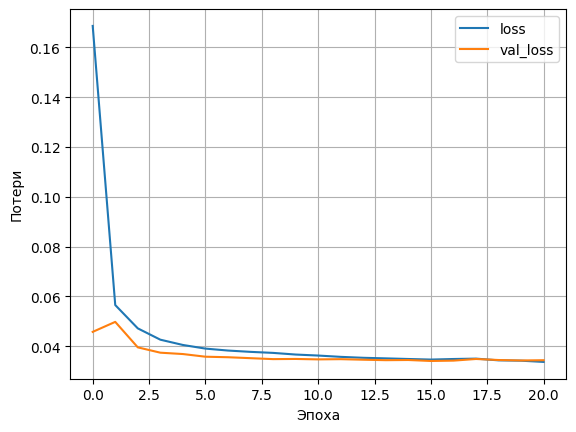

In [44]:
plot_loss(history_1)

In [ ]:
# Прогноз и оценка


# Предсказание нейросети
y_pred_1 = model_1.predict(features_test)

#score = model.evaluate(x_test, y_test, verbose=0)
#print("Test loss:", score[0])
#print("Test accuracy:", score[1])

In [ ]:

# датафрейм для сохранения метрик нейросетей

result_neural = pd.DataFrame(columns=['Модель',
                               'Прогнозируемая переменная',
                               #'Лучшие параметры',
                               'Среднеквадратическая ошибка (MSE)',
                               'Коэффициент детерминации (R^2)']
                      ).set_index(['Модель'])


In [ ]:
def get_metrics(model_name, y_test, y_pred):
    
           
    # оценка качества прогнозов на тестовой выборке
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # заполнение датафрейма оценками
    result_neural.loc[model_name] = ['Соотношение матрица-наполнитель',
                                      #best_param,   model_1.summary()
                                      f"{mse:.3f}",
                                      f"{r2:.3f} "]


In [ ]:
get_metrics('Нейросеть model_1', y_test, y_pred_1)

In [ ]:
result_neural

In [ ]:
describe y, y1, y2, ...
# или
error = y_test - test_predictions
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

### Модель 2

In [ ]:
model_2 = keras.Sequential([
          layers.Dense(24, activation='relu'),   # input_dim=12
          layers.Dense(12, activation='relu'),
          layers.Dense(1, activation='relu'),
])

In [ ]:
keras.utils.plot_model(model) # архитектура сети

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,6)) # метрики и функции потерь